In [1]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt

# Reading and Preprocessing Data

In [2]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df


In [3]:
alpha_up = read_excel('alpha_up')

GAMMA_TL = read_excel('GAMMA_TL')

w = read_excel('w')
w = mirroring(w)
w = set_same_zero(w)

TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

# TL_char = read_excel_revisi('TL_char')
# PL_char = read_excel_revisi('PL_char')
# PR_char = read_excel_revisi('PR_char')

beta_up = read_excel('beta_up')

gamma_uu = read_excel('gamma_uu')
gamma_uu = mirroring(gamma_uu)
gamma_uu = set_same_zero(gamma_uu)


SIGMA_PL = read_excel('SIGMA_PL')



sigma_pr = read_excel('sigma_pr')

PSI_PR = read_excel('PSI_PR')

z_pr = read_excel('z_pr')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')

In [4]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [5]:
special_P_port = special_PR.columns.to_list()
wave_status['PR_availability'] = wave_status['wave_h']<2

In [6]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

In [7]:
TL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL1')
TL2_data = pd.read_excel('Data Ship.xlsx', sheet_name='TL2')
PL1_data = pd.read_excel('Data Ship.xlsx', sheet_name='PL1')
PR_Ambon_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Ambon')
PR_Saumlaki_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Saumlaki')
PR_Tual_data = pd.read_excel('Data Ship.xlsx', sheet_name='PR_Tual')


#### Filling Data with Dummy Data

In [8]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

w = fill_mean(w)
SIGMA_PL = fill_mean(SIGMA_PL)
sigma_pr = fill_mean(sigma_pr)
z_pr = fill_mean(z_pr)
PSI_PR = fill_mean(PSI_PR)
PR_char = fill_mean(PR_char)
biaya_jarak_teus = fill_mean(biaya_jarak_teus)

# Data Dummy

In [9]:
all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)

# Creating Objects and Function

In [10]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [11]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [12]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [13]:
def find_distance(port_a,port_b):
    distance = np.random.rand()*100 #TODO: FIND DISTANCE
    return distance

In [14]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [15]:
def per_item_revenue(data):
    distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [16]:
def port_revenue(storage_df):
    total_income = 0
    for i in storage_df.index:
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [17]:
def item_left(df):
    return int(df['Bobot'].sum())

In [18]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [19]:
def all_item(available_ship):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [20]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [21]:
def get_route(df):
    return df['Route'].to_list()

In [22]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [23]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name'):
        self.name = name
        self.ship_type = ship_type
        self.route_n = 0
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        self.port_cycle = route
        self.counter = len(route)
        self.route_list = []
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        if ship_type == 'TL':
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()
    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]
    def move_port(self):
        if self.ship_type == 'TL':
            if self.current_port.name in special_P_port:
                added_port = find_movable_port(self.ship_type,self.current_port.name)
                self.cycle_list()
                self.counter += len(added_port)
                self.port_cycle = added_port+self.port_cycle
                
                    
            if self.current_port == 0:
                self.port_cycle = route
                self.current_port = len(route)
#                 self.port_cycle = [x for x in self.port_cycle if x not in create_route(R_list)]
#                 self.port_cycle = [self.current_port] + self.port_cycle
#                 self.counter=False

#         elif self.ship_type == 'PR':
#             if self.current_port.name in special_P_port:
#                 moveable_port = find_movable_port(self.ship_type,self.current_port.name) 
#                 self.port_cycle = [x for x in self.port_cycle if x in moveable_port ]
                
        self.counter -= self.counter
        self.cycle_list()
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        ship_char = choose_char(self.ship_type)

        Bobot = item['Bobot']
        bm_time = ship_char[self.current_port.name ]['bm_time']
        C_bm = ship_char[self.current_port.name ]['C_bm']
        inventory_cost = ship_char[self.current_port.name ]['inventory_cost']
        bm_time = ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = ship_char[self.current_port.name ]['avg_docking_time']
        distance = find_distance(item['Pelabuhan'],self.current_port.name )
        V = ship_char['ship_char']['V']
        VC = ship_char['ship_char']['VC']
        port_storage_time = ship_char[self.current_port.name ]['port_storage_time']
        C_storage = ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
        if finish_shipping == True:
            #CALCULATING SHIP REVENUE
#             print('%%%%%%%%%%%%%%%%%%%%%%%%')
#             print(port_revenue(ship_item))
#             print('%%%%%%%%%%%%%%%%%%%%%%%%')
            self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost


        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_port(self,port_destination):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == port_destination]
        self.current_port.demand = pd.concat([self.current_port.demand, port_item]).drop_duplicates(keep=False)
        self.storage = self.storage.append(port_item)
        self.update_storage_volume()
    
    def move_storage(self):
        

        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list()
                for i in current_port_R_ports:
                    self.drop_off_item(i,finish_shipping = False)


            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    if i.name == 'Tepa':
                        self.drop_off_item(i.name,finish_shipping = False)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
            
        #SPECIAL FOR PL SHIP: TAKE EVERYTHING with TANJUNG PERAK
        if self.ship_type == 'PL':
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)
#                 for i in R_list:
#                     self.pick_up_port(i)

        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.current_port.demand = pd.concat([self.current_port.demand, port_item]).drop_duplicates(keep=False)
                self.storage = self.storage.append(port_item)
                self.update_storage_volume()
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
#                 port_PR_ports = find_movable_port('TL',self.current_port.name)
                for i in R_list:
                    self.pick_up_port(i)
            #FOR PL
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list:
            port_item = self.current_port.demand
            self.current_port.demand = pd.concat([self.current_port.demand, port_item]).drop_duplicates(keep=False)
            self.storage = self.storage.append(port_item)
            self.update_storage_volume()
            
        # ITEM PICK UP--------------------------------------------------------
            
            
    
      
    def __repr__(self):
        return self.ship_type +': '+ self.ship_type


In [24]:
ports['port_object'] = ports['port'].apply(lambda x: quickport(x))

In [25]:
route_list = ['Tanjung Perak','Saumlaki','Tanjung Priok','Dobo','Namlea']
route = create_route(route_list)

In [26]:
route_list_TL1 = get_route(TL1_data)
route_TL1 = create_route(route_list_TL1)

route_list_TL2 = get_route(TL2_data)
route_TL2 = create_route(route_list_TL2)

route_list_PL1 = get_route(PL1_data)
route_PL1 = create_route(route_list_PL1)

route_list_PR_Ambon = get_route(PR_Ambon_data)
route_PR_Ambon = create_route(route_list_PR_Ambon)

route_list_PR_Tual = get_route(PR_Tual_data)
route_PR_Tual = create_route(route_list_PR_Tual)

route_list_PR_Saumlaki = get_route(PR_Saumlaki_data)
route_PR_Saumlaki = create_route(route_list_PR_Saumlaki)


In [27]:
TL_tester = Ship('TL',route)
TL1 = Ship('TL',route_TL1)
TL2 = Ship('TL',route_TL2)
PL1 = Ship('PL',route_PL1)
PR_Ambon = Ship('PR',route_PR_Ambon)
PR_Tual = Ship('PR',route_PR_Tual)
PR_Saumlaki = Ship('PR',route_PR_Saumlaki)



In [28]:
available_ship = [TL_tester,TL1,TL2,PL1,PR_Ambon,PR_Tual,PR_Saumlaki]

In [29]:
def port_sequence(ship):
    print('')
    print('')
    print('')
    print('')
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    print('ship_type: '+ship.ship_type)
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    print('BEFORE')
    print('current port:' + ship.current_port.name)
    print('')
    print('PORT DEMAND:')
    print(ship.current_port.demand)
    print('')
    print('SHIP STORAGE:')
    print(ship.storage)
    ship.move_storage()
    print('oOoOoOoOoOoOoOoOoOoOoOoO')
    print('AFTER')
    print('current port:' + ship.current_port.name)
    print('')
    print('PORT DEMAND:')
    print(ship.current_port.demand)
    print('')
    print('SHIP STORAGE:')
    print(ship.storage)
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
    ship.move_port()
    ship.route_n += 1


In [ ]:
new_port_item = all_item(available_ship)
remaining = item_left(new_port_item)
i=0
remaining_history = []
TL1_history = []
while remaining>0:
    i +=1
#     port_sequence(TL_tester)
    print('TL1')
    port_sequence(TL1)
    TL1_history.append(TL1.current_port.name)
    port_sequence(TL2)
    port_sequence(PL1)
    port_sequence(PR_Ambon)
    port_sequence(PR_Tual)
    port_sequence(PR_Saumlaki)
    new_port_item = all_item(available_ship)
    remaining = item_left(new_port_item)
    print('************************************************')
    print('remaining: ' + str(remaining))
    remaining_history.append(remaining)
    print('iteration: ' + str(i))
    print('************************************************')

    if i>=800:
        break



TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa    68               Fogi
A243       Moa    50             Manipa
A341       Moa    72             Manipa
A248       Moa    16    

************************************************
remaining: 4939
iteration: 1
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa  

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 2
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar1

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai


************************************************
remaining: 4939
iteration: 3
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A154       Moa    69    Tanjung Priok
A178       Moa    66         Werinama

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 4
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A

Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Holat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Serua

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 5
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 6
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Teon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Teon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 7
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 8
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A154       Moa    69    Tanjung Priok
A178       Moa    66         Werinama

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A3

************************************************
remaining: 4939
iteration: 9
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Molu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa    6

************************************************
remaining: 4939
iteration: 10
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ilwaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


current port:Tabarfane

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tabarfane

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ilwaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ilwaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
***

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namlea

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Jerol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Jerol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Romang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP S

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Meror

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Meror

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Leti

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 14
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Marlasi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lakor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lakor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 15
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lelam Kojabi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 16
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 17
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 18
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kisar

PORT DEMAND:
    Pelabuhan Bobot Tujuan Pelabuhan
A99     Kisar    36           Kaisui

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 19
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kisar1

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Da

************************************************
remaining: 4939
iteration: 20
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa   

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Larat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 21
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kailakat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 22
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kesui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 23
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kasiui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kasiui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wunlah

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Priok

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot Tujuan Pelabuhan
A183  Makassar     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Tior

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Inde

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
          Pelabuhan Bobot Tujuan Pelabuhan
A183  Tanjung Perak     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kobisadar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kobisadar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot Tujuan Pelabuhan
A183  Makassar     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Bula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Bula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mangur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimoi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Fadol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Fadol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tutukembong

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []



oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kelimuri

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Adault/Lingat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: [

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Marsela

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 30
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43       

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tam

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tepa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tepa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 31
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$

************************************************
remaining: 4939
iteration: 32
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Leti

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa  

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 33
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
          Pelabuhan Bobot Tujuan Pelabuhan
A183  Tanjung Perak     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Elat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelab

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot Tujuan Pelabuhan
A183  Makassar     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wamsisi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Banda Eli

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Eli

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Serua

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Leksula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Benjina

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Benjina

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHI

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tabarfane

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Teon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Teon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 38
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Jerol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 39
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Meror

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Bebar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Bebar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 40
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$

************************************************
remaining: 4939
iteration: 41
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Romang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa  

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ilwaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 42
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A154       Moa    69    Tanjung Priok
A178       Moa    66         Werinama

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Romang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 43
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Molu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 44
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current p

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dobo

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dobo

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Leti

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STOR

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Neira

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lakor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lakor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 46
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Manawoka

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 47
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 48
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 49
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namlea

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/D

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kisar

PORT DEMAND:
    Pelabuhan Bobot Tujuan Pelabuhan
A99     Kisar    36           Kaisui

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 50
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/D

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kisar1

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 51
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A154       Moa    69    Tanjung Priok
A178       Moa    66         Werinama

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang


AFTER
current port:Werinama

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Tior

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Tior

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Larat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFram

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ambon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namlea

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Mangur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Mangur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Fadol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Fadol

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Wunlah

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP 

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Kur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Seira

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Seira

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 56
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$

current port:Wamsisi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wamsisi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Toyando

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Toyando

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tanjung Perak

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
          Pelabuhan Bobot Tujuan Pelabuhan
A183  Tanjung Perak     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Leksula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Leksula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tam

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabu

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Makassar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot Tujuan Pelabuhan
A183  Makassar     7         Werinama
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Holat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHI

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Weduar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Adault/Lingat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Adaul

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Marsela

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 61
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Taniwel

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/D

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Mun

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tepa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tepa

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 62
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Banda Eli

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Dawera/Dawelor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 63
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Benjina

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kroing

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 64
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lewa/Dai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 65
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Geser

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Moa

PORT DEMAND:
     Pelabuhan Bobot Tujuan Pelabuhan
A154       Moa    69    Tanjung Priok
A178       Moa    66         Werinama

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 66
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Waemulang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lela

************************************************
remaining: 4939
iteration: 67
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa  

Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Longgar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Nila

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
**********************************************

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Bula

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Marlasi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Marlasi

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Teon

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP S

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Wulur

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 70
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tual

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Bebar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Bebar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 71
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Eray

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Eray

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 72
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Lua

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Ilwaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 73
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Da

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Manawoka

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Romang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Romang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 74
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Gorom

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Arwala/Sutilirang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 75
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: T

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Namrole

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kailakat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kailakat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Leti

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lakor

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 77
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Amahai

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai


oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kasiui

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Luang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 78
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:P.Tior

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Lelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Lelang

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 79
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kaimer

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Saumlaki

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 80
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Kisar

PORT DEMAND:
    Pelabuhan Bobot Tujuan Pelabuhan
A99     Kisar    36           Kaisui

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 81
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Taniwel

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/D

************************************************
remaining: 4939
iteration: 82
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tifu

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai
A188       Moa    29           Lewa/Dai
A75     Ilwaki    12            Kelimoi
A257    Ilwaki    73             Lelang
A251     Serua    36     Dawera/Dawelor
A252      Nila    53             Wunlah
A4      Namlea    93     Dawera/Dawelor
A146       Moa    

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Larat

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 83
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Ambalau

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43           Lewa/Dai

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Sofyanin/Rumayaan

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
************************************************
remaining: 4939
iteration: 84
************************************************
TL1




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: TL
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Kobisadar

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
     Pelabuhan Bobot   Tujuan Pelabuhan
A280  Saumlaki    12           Kelimuri
A155   Marsela    16               Fogi
A340    Kroing    11            Marlasi
A172   P.Luang    46           Kelimuri
A72      Wulur    66             Manipa
A163     Wulur    46           Werinama
A254     Wulur    59           Werinama
A76     Romang    78             Lelang
A349    Romang    43     

oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Buano

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Tam

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
oOoOoOoOoOoOoOoOoOoOoOoO
AFTER
current port:Tam

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAGE:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$




$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ship_type: PR
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
BEFORE
current port:Rumean

PORT DEMAND:
Empty DataFrame
Columns: [Pelabuhan, Bobot, Tujuan Pelabuhan]
Index: []

SHIP STORAG

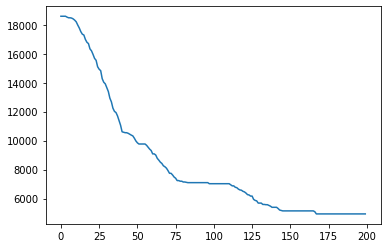

In [31]:
plt.plot(remaining_history)

In [32]:
TL1_history

['Saumlaki',
 'Marsela',
 'Kroing',
 'P.Luang',
 'Kisar1',
 'Wulur',
 'Rumean',
 'Seira',
 'Kisar',
 'Romang',
 'Moa',
 'Molu',
 'Ilwaki',
 'Larat',
 'Serua',
 'Sofyanin/Rumayaan',
 'Nila',
 'Namlea',
 'Namrole',
 'Moa',
 'Kisar',
 'Dobo',
 'Ambon',
 'P.Geser',
 'Waemulang',
 'Amahai',
 'Wamsisi',
 'Namrole',
 'Kelang',
 'Taniwel',
 'Tifu',
 'Ambalau',
 'Tanjung Perak',
 'Saumlaki',
 'Marsela',
 'Kroing',
 'P.Luang',
 'Kisar1',
 'Wulur',
 'Rumean',
 'Seira',
 'Kisar',
 'Romang',
 'Moa',
 'Molu',
 'Ilwaki',
 'Larat',
 'Serua',
 'Sofyanin/Rumayaan',
 'Nila',
 'P.Leti',
 'Marsela',
 'Kroing',
 'P.Luang',
 'Kisar1',
 'Wulur',
 'Rumean',
 'Seira',
 'Kisar',
 'Romang',
 'Moa',
 'Molu',
 'Ilwaki',
 'Larat',
 'Serua',
 'Sofyanin/Rumayaan',
 'Nila',
 'Namlea',
 'Namrole',
 'Moa',
 'Kisar',
 'Dobo',
 'Ambon',
 'P.Geser',
 'Waemulang',
 'Amahai',
 'Wamsisi',
 'Namrole',
 'Kelang',
 'Taniwel',
 'Tifu',
 'Ambalau',
 'Kobisadar',
 'P.Geser',
 'Waemulang',
 'Amahai',
 'Wamsisi',
 'Namrole',
 'Kelang'

In [33]:
wave_status[wave_status['Port'] == 'P.Manawoka']

,Port,wave_h,PR_availability
30,P.Manawoka,1.676792,True


In [34]:
ship_type = 'PR'
port_name = 'Ambon'
if ship_type == 'TL':
    flag = False
elif ship_type == 'PR':
    flag = True
else:
    added_route = []
r_list = special_PR[port_name].dropna().to_list()
route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
added_route = []
for i in route_list:
    added_route.append(chooseport(i))


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [35]:
special_PR

,Ambon,Tual,Saumlaki
0,Namlea,Dobo,Kisar
1,Namrole,Banda Neira,Kisar1
2,Ambalau,P.Manawoka,Larat
3,Wamsisi,Gorom,Sofyanin/Rumayaan
4,Leksula,Kailakat,Rumean
5,Tifu,P.Kesui,Wunlah
6,Waemulang,Kasiui,Seira
7,Fogi,P.Tior,Nurkat
8,Manipa,Kaimer,Molu
9,Kelang,Mangur,Tutukembong


### 